CELL 1 — Install required packages

In [24]:
# Cell 1 — Install packages (run once)
import tensorflow as tf
print("TensorFlow", tf.__version__)


TensorFlow 2.19.0


CELL 2 — Mount Google Drive

In [2]:
# Cell 2 — Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set base path in your Drive (change name if you want)
BASE_DRIVE = "/content/drive/MyDrive/HAM_project"
import os
os.makedirs(BASE_DRIVE, exist_ok=True)
os.makedirs(os.path.join(BASE_DRIVE, "masks"), exist_ok=True)
os.makedirs(os.path.join(BASE_DRIVE, "metadata"), exist_ok=True)
os.makedirs(os.path.join(BASE_DRIVE, "checkpoints"), exist_ok=True)
print("Base folder:", BASE_DRIVE)


Mounted at /content/drive
Base folder: /content/drive/MyDrive/HAM_project


CELL 3 — Upload kaggle.json and configure Kaggle

In [3]:
# Cell 3 — Upload kaggle.json (use file chooser)
from google.colab import files
import os, shutil

print("Upload kaggle.json (from your Kaggle account -> Account -> Create New API Token)")
uploaded = files.upload()  # choose kaggle.json from your PC

# Move to ~/.kaggle
os.makedirs('/root/.kaggle', exist_ok=True)
for fn in uploaded:
    shutil.move(fn, '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)
!kaggle --version


Upload kaggle.json (from your Kaggle account -> Account -> Create New API Token)


Saving kaggle.json to kaggle.json
Kaggle API 1.7.4.5


CELL 4 — Download HAM10000 and optional segmentation masks

In [4]:
# Cell 4 — Download HAM10000 (Kaggle) and the segmentation masks dataset (optional)
# This will download into /content; we'll move necessary files to Drive after unzip.
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content --unzip
!kaggle datasets download -d yesbutoya/ham10000-segmentation-masks -p /content --unzip

# Move files to Drive base
import shutil, glob
# Move CSV(s) and images
for f in glob.glob("/content/*ham*"):
    try:
        shutil.move(f, BASE_DRIVE)
    except Exception as e:
        print("Move error:", e)

# If masks downloaded, move them into masks folder
for f in glob.glob("/content/*mask*"):
    try:
        # Many masks are inside a folder named masks or segmentation-masks
        if os.path.isdir(f):
            for m in glob.glob(os.path.join(f, "*")):
                shutil.move(m, os.path.join(BASE_DRIVE, "masks"))
        else:
            shutil.move(f, os.path.join(BASE_DRIVE, "masks"))
    except Exception as e:
        print("Mask move error:", e)

print("Files in project folder:", os.listdir(BASE_DRIVE)[:20])
print("Masks folder count:", len(os.listdir(os.path.join(BASE_DRIVE,"masks"))))


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 99% 5.14G/5.20G [02:13<00:03, 18.5MB/s]
100% 5.20G/5.20G [02:13<00:00, 41.9MB/s]
403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/yesbutoya/ham10000-segmentation-masks
Move error: Destination path '/content/drive/MyDrive/HAM_project/ham10000_images_part_2' already exists
Move error: Destination path '/content/drive/MyDrive/HAM_project/ham10000_images_part_1' already exists
Files in project folder: ['masks', 'metadata', 'checkpoints', 'ham10000_images_part_2', 'ham10000_images_part_1', 'images']
Masks folder count: 0


CELL 5 — Build unified metadata.csv (melanoma binary label) and quick inspect

In [5]:
# FIXED CELL 5 — Build metadata.csv correctly

import pandas as pd, os, shutil

BASE_DRIVE = "/content/drive/MyDrive/HAM_project"
META_IN = "/content/HAM10000_metadata.csv"  # Actual location
META_OUT = os.path.join(BASE_DRIVE, "metadata", "metadata.csv")

# Copy metadata file into Drive
shutil.copy(META_IN, os.path.join(BASE_DRIVE, "metadata", "HAM10000_metadata.csv"))

df = pd.read_csv(META_IN)

# filename = image_id + ".jpg"
df['filename'] = df['image_id'].astype(str) + '.jpg'

# Label: melanoma = 1, others = 0
df['label'] = (df['dx'] == 'mel').astype(int)

# Map masks (currently none)
MASKS_DIR = os.path.join(BASE_DRIVE, "masks")
mask_list = set(os.listdir(MASKS_DIR))

def find_mask(fn):
    base = os.path.splitext(fn)[0]
    return base if base in mask_list else ""

df['mask_filename'] = df['filename'].apply(find_mask)

# Add placeholder skin_bin
df['skin_bin'] = -1

# Save final metadata.csv
df[['filename','label','mask_filename','skin_bin']].to_csv(META_OUT, index=False)

print("Unified metadata saved to:", META_OUT)
df.head()


Unified metadata saved to: /content/drive/MyDrive/HAM_project/metadata/metadata.csv


,lesion_id,image_id,dx,dx_type,age,sex,localization,filename,label,mask_filename,skin_bin
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg,0,,-1
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg,0,,-1
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg,0,,-1
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg,0,,-1
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg,0,,-1


In [6]:
# CELL 5.5 — Create images/ folder and move all images into it

import os, glob, shutil

BASE_DRIVE = "/content/drive/MyDrive/HAM_project"
IMG_DIR = os.path.join(BASE_DRIVE, "images")
os.makedirs(IMG_DIR, exist_ok=True)

parts = [
    os.path.join(BASE_DRIVE, "ham10000_images_part_1"),
    os.path.join(BASE_DRIVE, "ham10000_images_part_2")
]

moved = 0
for part in parts:
    if os.path.exists(part):
        for img in glob.glob(os.path.join(part, "*.jpg")):
            dst = os.path.join(IMG_DIR, os.path.basename(img))
            if not os.path.exists(dst):
                shutil.move(img, dst)
                moved += 1

print("Moved images:", moved)
print("Total images in images/:", len(os.listdir(IMG_DIR)))


Moved images: 0
Total images in images/: 10015


CELL 6 — Quick EDA: counts and class balance

In [7]:
# Cell 6 — Quick analysis
import numpy as np
df = pd.read_csv(os.path.join(BASE_DRIVE,"metadata","metadata.csv"))
print("Total images:", len(df))
print("Label counts:\n", df['label'].value_counts())
print("Has mask count:", (df['mask_filename']!="" ).sum())
df.sample(5)


Total images: 10015
Label counts:
 label
0    8902
1    1113
Name: count, dtype: int64
Has mask count: 10015


,filename,label,mask_filename,skin_bin
8291,ISIC_0025545.jpg,0,NaN,-1
5902,ISIC_0031054.jpg,0,NaN,-1
3190,ISIC_0031106.jpg,0,NaN,-1
6,ISIC_0029176.jpg,0,NaN,-1
8020,ISIC_0033177.jpg,0,NaN,-1


CELL 7 — ITA-based skin-tone estimator (fast) and fill skin_bin in metadata

In [8]:
# Cell 7 — ITA estimator to approximate skin_bin (fast, heuristic)
# We'll use a center patch to compute ITA and map to Fitzpatrick-like bins.

import cv2
import numpy as np
from tqdm import tqdm

def rgb_to_ita_patch(img_rgb):
    # img_rgb: uint8
    try:
        img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
    except:
        img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB).astype(np.float32)
    L = img_lab[:,:,0]
    b = img_lab[:,:,2]
    ita = np.degrees(np.arctan2((L - 50.), b + 1e-8))
    return np.nanmedian(ita)

def ita_to_bin(ita):
    # thresholds approximate Fitzpatrick grouping
    if ita > 41: return 0
    if ita > 28: return 1
    if ita > 10: return 2
    if ita > -30: return 3
    if ita > -48: return 4
    return 5

# Fill skin_bin for metadata (run on a subset first if you want)
IMG_DIR = BASE_DRIVE  # images are in BASE_DRIVE folder
meta_path = os.path.join(BASE_DRIVE,"metadata","metadata.csv")
df = pd.read_csv(meta_path)
if 'skin_bin' not in df.columns:
    df['skin_bin'] = -1

# We'll only compute for images that don't have skin_bin set to speed up
to_compute = df[df['skin_bin'] == -1]['filename'].tolist()
print("Computing skin_bin for", len(to_compute), "images (this may take a few minutes)...")
for fname in tqdm(to_compute):
    p = os.path.join(IMG_DIR, fname)
    if not os.path.exists(p):
        continue
    im = cv2.imread(p)
    if im is None:
        continue
    h,w = im.shape[:2]
    ph = max(10, h//6)
    pw = max(10, w//6)
    patch = im[h//2-ph:h//2+ph, w//2-pw:w//2+pw]
    if patch.size == 0:
        continue
    ita = rgb_to_ita_patch(patch)
    df.loc[df['filename']==fname, 'skin_bin'] = ita_to_bin(ita)

# Save back
df.to_csv(meta_path, index=False)
print("Updated metadata with skin_bin. Example counts:")
print(df['skin_bin'].value_counts(dropna=False))


Computing skin_bin for 10015 images (this may take a few minutes)...


100%|██████████| 10015/10015 [00:00<00:00, 13499.96it/s]

Updated metadata with skin_bin. Example counts:
skin_bin
-1    10015
Name: count, dtype: int64


CELL 8 — Build tf.data pipelines (with optional balanced sampling)

In [9]:
# FIXED CELL 8 — tf.data loader

import tensorflow as tf
import pandas as pd
import os

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 384        # Adjust as needed
BATCH_SIZE = 8

BASE_DRIVE = "/content/drive/MyDrive/HAM_project"
IMG_DIR = os.path.join(BASE_DRIVE, "images")   # <-- FIXED
MASK_DIR = os.path.join(BASE_DRIVE, "masks")

meta = pd.read_csv(os.path.join(BASE_DRIVE, "metadata", "metadata.csv"))

# Split
train_df = meta.sample(frac=0.7, random_state=42)
tmp_df = meta.drop(train_df.index)
val_df = tmp_df.sample(frac=0.5, random_state=42)
test_df = tmp_df.drop(val_df.index)

print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))

def _load_and_preprocess(img_path, mask_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img - 0.5) * 2.0    # rescale to [-1, 1]

    # Load mask if exists
    def load_mask(p):
        m = tf.io.read_file(p)
        m = tf.image.decode_png(m, channels=1)
        m = tf.image.convert_image_dtype(m, tf.float32)
        m = tf.image.resize(m, [IMG_SIZE, IMG_SIZE])
        return m

    mask = tf.cond(tf.strings.length(mask_path) > 0,
                   lambda: load_mask(mask_path),
                   lambda: tf.zeros([IMG_SIZE, IMG_SIZE, 1], tf.float32))

    return img, mask, tf.cast(label, tf.float32)

def df_to_dataset(df, batch_size=BATCH_SIZE, shuffle=True, augment=False):
    img_paths = [os.path.join(IMG_DIR, fn) for fn in df['filename']]
    mask_paths = [os.path.join(MASK_DIR, m) if isinstance(m, str) and len(m) > 0 else "" for m in df['mask_filename']]
    labels = df['label'].values

    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=4096, reshuffle_each_iteration=True)

    def _parse(img_path, mask_path, label):
        img, mask, lab = _load_and_preprocess(img_path, mask_path, label)
        return {"image": img, "mask": mask, "label": lab}

    ds = ds.map(_parse, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = df_to_dataset(train_df, augment=True)
val_ds   = df_to_dataset(val_df)
test_ds  = df_to_dataset(test_df)

# Quick test
for batch in train_ds.take(1):
    print("Image batch:", batch["image"].shape)
    print("Mask batch:", batch["mask"].shape)
    print("Label batch:", batch["label"].shape)


Train/Val/Test sizes: 7010 1502 1503
Image batch: (8, 384, 384, 3)
Mask batch: (8, 384, 384, 1)
Label batch: (8,)


CELL 9 — Build ResNet50-based multi-task model (simple, clear)

In [10]:
# Cell 9 — Model: ResNet50 encoder + small U-Net decoder + classification head
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def build_resnet_unet(input_shape=(IMG_SIZE,IMG_SIZE,3)):
    base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    # pick skip connections
    skip1 = base.get_layer("conv1_relu").output    # /2
    skip2 = base.get_layer("conv2_block3_out").output  # /4
    skip3 = base.get_layer("conv3_block4_out").output  # /8
    last  = base.get_layer("conv4_block6_out").output  # /16  (conv5 exists; we take conv4 for memory)
    # you can also use conv5_block3_out (deeper) if memory allows

    # decoder
    x = last
    x = layers.UpSampling2D()(x)  # x/8
    x = layers.Concatenate()([x, skip3])
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D()(x)  # x/4
    x = layers.Concatenate()([x, skip2])
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D()(x)  # x/2
    x = layers.Concatenate()([x, skip1])
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D()(x)  # x/1 -> IMG_SIZE
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    seg_out = layers.Conv2D(1, 1, activation='sigmoid', name='seg_output')(x)

    # classification head from a deep feature (use base.output / conv5 area)
    # Use base.output (conv5_block3_out) if available; else use last
    cls_feat = base.output  # deep features
    gap = layers.GlobalAveragePooling2D()(cls_feat)
    gap = layers.Dropout(0.4)(gap)
    logits = layers.Dense(1, name='cls_logits')(gap)
    cls_out = layers.Activation('sigmoid', name='cls_output')(logits)

    model = Model(inputs=base.input, outputs=[seg_out, cls_out])
    return model

model = build_resnet_unet()
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 390, 390,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 192, 192,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 192, 192,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 192, 192,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 194, 194,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 96, 96,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 96, 96,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 96, 96,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 96, 96,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 96, 96,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 96, 96,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 96, 96,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 96, 96,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 96, 96,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_3_c

 Total params: 28,622,658 (109.19 MB)

 Trainable params: 28,569,538 (108.98 MB)

 Non-trainable params: 53,120 (207.50 KB)

CELL 10 — Loss functions (Dice, BCE) and CAM helper (simple)

In [11]:
# Cell 10 — Losses and CAM
import tensorflow.keras.backend as K

# Dice
def dice_coef(y_true, y_pred, eps=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = 2.0 * K.sum(y_true_f * y_pred_f) + eps
    denom = K.sum(y_true_f) + K.sum(y_pred_f) + eps
    return intersection / denom

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Binary crossentropy for classification
bce = tf.keras.losses.BinaryCrossentropy()

# CAM helper: compute CAM from deep features and classifier kernel
def compute_cam(features, cls_kernel):
    # features: [B,h,w,c], cls_kernel: [c] or [c,1]
    cam = tf.tensordot(features, cls_kernel, axes=[[3],[0]])  # [B,h,w]
    cam = tf.expand_dims(cam, axis=-1)  # [B,h,w,1]
    cam = tf.image.resize(cam, (IMG_SIZE, IMG_SIZE))
    # normalize per-image
    minv = tf.reduce_min(cam, axis=[1,2,3], keepdims=True)
    maxv = tf.reduce_max(cam, axis=[1,2,3], keepdims=True)
    cam = (cam - minv) / (maxv - minv + 1e-8)
    return cam

# Explainability loss: MSE + (1 - mass_inside)
def explainability_loss(cam, seg):
    mse = tf.reduce_mean(tf.square(cam - seg))
    cam_flat = tf.reshape(cam, (tf.shape(cam)[0], -1))
    seg_flat = tf.reshape(seg, (tf.shape(seg)[0], -1))
    mass_inside = tf.reduce_sum(cam_flat * seg_flat, axis=1) / (tf.reduce_sum(cam_flat, axis=1) + 1e-8)
    mass_loss = tf.reduce_mean(1.0 - mass_inside)
    return mse + mass_loss


CELL 11 — Bias penalty helper (simple per-batch approximator) and metrics (AUC, Sens@95)

In [12]:
# Cell 11 — Bias penalty (approx) and metrics
import numpy as np
from sklearn.metrics import roc_auc_score

def bias_penalty(preds, labels, skin_bins, num_bins=6):
    # preds: numpy or tf array of shape (B,)
    preds = np.array(preds).reshape(-1)
    labels = np.array(labels).reshape(-1)
    skin_bins = np.array(skin_bins).reshape(-1)
    overall_bce = np.mean(tf.keras.losses.binary_crossentropy(labels, preds))
    penalty = 0.0
    for g in range(num_bins):
        mask = (skin_bins == g)
        if mask.sum() < 5:  # skip tiny groups
            continue
        group_bce = np.mean(tf.keras.losses.binary_crossentropy(labels[mask], preds[mask]))
        penalty += abs(group_bce - overall_bce)
    return penalty

def sensitivity_at_specificity(y_true, y_score, specificity=0.95):
    # Return sensitivity at given specificity
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    spec = 1 - fpr
    # find threshold where spec >= requested, choose max tpr
    mask = spec >= specificity
    if mask.sum() == 0:
        return 0.0
    return max(tpr[mask])


CELL 12 — Training loop (custom, simple, with explainability + bias sampling option)

In [13]:
# =============================================================
# CELL 12 — FIXED Training Loop (Classification + CAM Explainability)
# =============================================================

import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# -------------------------
# Loss weights
# -------------------------
alpha_cls = 1.0           # classification loss
beta_explain = 1.0        # CAM explainability loss


# -------------------------
# 1) CLASSIFIER LAYER
# -------------------------
cls_layer = model.get_layer("cls_logits")   # Dense layer before sigmoid


# -------------------------
# 2) CORRECT CAM FEATURE LAYER
#    ResNet50 final conv block = conv5_block3_out (2048 channels)
# -------------------------
deep_conv_layer = "conv5_block3_out"

print("Using CAM feature layer:", deep_conv_layer)

feature_extractor = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(deep_conv_layer).output
)


# -------------------------
# 3) TRAINING STEP
# -------------------------
@tf.function
def train_step(imgs, labels):
    with tf.GradientTape() as tape:
        seg_pred, cls_pred = model(imgs, training=True)

        # -------- Classification Loss --------
        labels = tf.reshape(labels, (-1, 1))
        loss_cls = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(labels, cls_pred)
        )

        # -------- CAM Explainability --------
        features = feature_extractor(imgs, training=True)  # (B,H,W,2048)
        cls_kernel = cls_layer.kernel[:, 0]                 # (2048,)

        # Raw CAM
        cam = compute_cam(features, cls_kernel)             # (B,H,W,1)

        # Pseudo-mask = strong CAM thresholding
        pseudo_mask = tf.cast(cam > 0.6, tf.float32)

        loss_explain = beta_explain * explainability_loss(cam, pseudo_mask)

        # -------- Total Loss --------
        loss = loss_cls + loss_explain

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss, loss_cls, loss_explain


# -------------------------
# 4) VALIDATION (classification only)
# -------------------------
def validate(model, val_ds):
    y_true = []
    y_scores = []

    for batch in val_ds:
        imgs = batch["image"]
        labels = batch["label"].numpy()

        _, cls_pred = model(imgs, training=False)

        y_true.extend(labels.tolist())
        y_scores.extend(cls_pred.numpy().reshape(-1).tolist())

    auc = roc_auc_score(y_true, y_scores)
    sens95 = sensitivity_at_specificity(y_true, y_scores, specificity=0.95)

    return {"AUC": auc, "Sens95": sens95}


# -------------------------
# 5) TRAINING LOOP
# -------------------------
EPOCHS = 5  # sanity run
best_auc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    step = 0
    for batch in train_ds:
        imgs = batch["image"]
        labels = batch["label"]

        loss, loss_cls, loss_exp = train_step(imgs, labels)

        if step % 50 == 0:
            print(
                f"Step {step} | "
                f"Total: {loss.numpy():.4f} | "
                f"CLS: {loss_cls.numpy():.4f} | "
                f"CAM: {loss_exp.numpy():.4f}"
            )
        step += 1

    # ---- VALIDATE ----
    metrics_val = validate(model, val_ds)
    print("VAL:", metrics_val)

    # ---- SAVE BEST MODEL ----
    if metrics_val["AUC"] > best_auc:
        best_auc = metrics_val["AUC"]
        save_path = os.path.join(
            BASE_DRIVE, "checkpoints",
            f"best_epoch{epoch+1}_auc{best_auc:.4f}.weights.h5"
        )
        model.save_weights(save_path)
        print("Saved checkpoint:", save_path)



Using CAM feature layer: conv5_block3_out

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['conv2d/kernel', 'conv2d/bias', 'conv2d_1/kernel', 'conv2d_1/bias', 'conv2d_2/kernel', 'conv2d_2/bias', 'conv2d_3/kernel', 'conv2d_3/bias', 'conv2d_4/kernel', 'conv2d_4/bias', 'conv2d_5/kernel', 'conv2d_5/bias', 'conv2d_6/kernel', 'conv2d_6/bias', 'seg_output/kernel', 'seg_output/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Step 0 | Total: 1.8848 | CLS: 0.9662 | CAM: 0.9186
Step 50 | Total: 1.3697 | CLS: 0.4269 | CAM: 0.9428
Step 100 | Total: 1.4958 | CLS: 0.6829 | CAM: 0.8129
Step 150 | Total: 1.0253 | CLS: 0.3439 | CAM: 0.6814
Step 200 | Total: 1.1933 | CLS: 0.5229 | CAM: 0.6704
Step 250 | Total: 0.9773 | CLS: 0.3338 | CAM: 0.6435
Step 300 | Total: 0.8914 | CLS: 0.2880 | CAM: 0.6034
Step 350 | Total: 0.8357 | CLS: 0.2377 | CAM: 0.5980
Step 400 | Total: 0.6887 | CLS: 0.1217 | CAM: 0.5670
Step 450 | Total: 0.9223 | CLS: 0.3676 | CAM: 0.5548
Step 500 | Total: 0.6512 | CLS: 0.1052 | CAM: 0.5460
Step 550 | Total: 0.6354 | CLS: 0.1066 | CAM: 0.5289
Step 600 | Total: 1.0233 | CLS: 0.4998 | CAM: 0.5235
Step 650 | Total: 0.5880 | CLS: 0.0683 | CAM: 0.5197
Step 700 | Total: 0.6456 | CLS: 0.1331 | CAM: 0.5124
Step 750 | Total: 0.5656 | CLS: 0.0737 | CAM: 0.4920
Step 800 | Total: 0.6644 | CLS: 0.1721 | CAM: 0.4923
Step 850 | Total: 0.6081 | CLS: 0.1109 | CAM: 0.4973
VAL: {'AUC': np.float64(0.8798013112745642), 'Sen

In [15]:
# =============================================================
# CELL 12.1 — Training Utilities (EarlyStopping, LR Scheduler, Logging)
# =============================================================

import numpy as np
import pandas as pd
import os
import time

# -------------------------------------------------------------
# Training history dictionary
# -------------------------------------------------------------
history = {
    "epoch": [],
    "train_loss": [],
    "train_cls_loss": [],
    "train_cam_loss": [],
    "val_auc": [],
    "val_sens95": [],
    "lr": []
}

# -------------------------------------------------------------
# Early Stopping settings
# -------------------------------------------------------------
patience = 5
wait = 0
best_auc = -1
early_stop = False

# -------------------------------------------------------------
# Learning Rate Scheduler (manual ReduceLROnPlateau)
# -------------------------------------------------------------
def adjust_learning_rate(optimizer, val_auc, best_auc):
    """Reduce LR when AUC plateaus (Keras 3 compatible)."""

    old_lr = float(optimizer.learning_rate.numpy())

    # If AUC improved → no LR change
    if val_auc > best_auc:
        return old_lr

    # If not improved → reduce LR by factor 0.5
    new_lr = max(old_lr * 0.5, 1e-6)
    optimizer.learning_rate.assign(new_lr)
    return new_lr


# -------------------------------------------------------------
# Training Loop (Extended)
# -------------------------------------------------------------
EPOCHS = 20  # Now a proper full training run

for epoch in range(EPOCHS):
    print(f"\n================ Epoch {epoch+1}/{EPOCHS} ================")

    # ---------------------------
    # TRAINING PHASE
    # ---------------------------
    epoch_loss = []
    epoch_cls = []
    epoch_cam = []

    step = 0
    for batch in train_ds:
        imgs = batch["image"]
        labels = batch["label"]

        loss, loss_cls, loss_cam = train_step(imgs, labels)

        epoch_loss.append(loss.numpy())
        epoch_cls.append(loss_cls.numpy())
        epoch_cam.append(loss_cam.numpy())

        if step % 50 == 0:
            print(
                f"Step {step} | "
                f"Total: {loss.numpy():.4f} | "
                f"CLS: {loss_cls.numpy():.4f} | "
                f"CAM: {loss_cam.numpy():.4f}"
            )
        step += 1

    train_loss = np.mean(epoch_loss)
    train_cls = np.mean(epoch_cls)
    train_cam = np.mean(epoch_cam)

    # ---------------------------
    # VALIDATION PHASE
    # ---------------------------
    metrics = validate(model, val_ds)
    val_auc = metrics["AUC"]
    val_sens95 = metrics["Sens95"]

    print(f"\nVAL → AUC: {val_auc:.4f}, Sens@95: {val_sens95:.4f}")

    # ---------------------------
    # LEARNING RATE UPDATE
    # ---------------------------
    current_lr = adjust_learning_rate(optimizer, val_auc, best_auc)
    print("Current LR =", current_lr)

    # # ---------------------------
    # # SAVE BEST MODEL
    # # ---------------------------
    # if val_auc > best_auc:
    #     best_auc = val_auc
    #     wait = 0
    #     save_path = os.path.join(
    #         BASE_DRIVE, "checkpoints",
    #         f"best_AUC_{best_auc:.4f}_epoch{epoch+1}.h5"
    #     )
    #     model.save_weights(save_path)
    #     print("✔ Model improved. Saved:", save_path)
    # else:
    #     wait += 1
    #     print(f"No improvement. Patience = {wait}/{patience}")


    # ---------------------------
    # SAVE BEST MODEL (FIXED)
    # ---------------------------
    if val_auc > best_auc:
        best_auc = val_auc
        wait = 0
        save_path = os.path.join(
            BASE_DRIVE, "checkpoints",
            f"best_AUC_{best_auc:.4f}_epoch{epoch+1}.weights.h5"
        )
        model.save_weights(save_path)
        print("✔ Model improved. Saved:", save_path)
    else:
        wait += 1
        print(f"No improvement. Patience = {wait}/{patience}")




    # ---------------------------
    # EARLY STOPPING CONDITION
    # ---------------------------
    if wait >= patience:
        print("⛔ Early stopping triggered. Training stopped.")
        early_stop = True
        break

    # ---------------------------
    # LOG HISTORY
    # ---------------------------
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(train_loss)
    history["train_cls_loss"].append(train_cls)
    history["train_cam_loss"].append(train_cam)
    history["val_auc"].append(val_auc)
    history["val_sens95"].append(val_sens95)
    history["lr"].append(current_lr)


# -------------------------------------------------------------
# Save Training Log to Drive
# -------------------------------------------------------------
history_df = pd.DataFrame(history)
log_path = os.path.join(BASE_DRIVE, "training_log.csv")
history_df.to_csv(log_path, index=False)
print("\nTraining log saved to:", log_path)
print(history_df.tail())



================ Epoch 1/20 ================
Step 0 | Total: 0.4518 | CLS: 0.0489 | CAM: 0.4029
Step 50 | Total: 1.0057 | CLS: 0.6046 | CAM: 0.4011
Step 100 | Total: 0.4956 | CLS: 0.0838 | CAM: 0.4118
Step 150 | Total: 0.3998 | CLS: 0.0156 | CAM: 0.3842
Step 200 | Total: 0.3933 | CLS: 0.0077 | CAM: 0.3856
Step 250 | Total: 0.4272 | CLS: 0.0229 | CAM: 0.4042
Step 300 | Total: 0.3982 | CLS: 0.0051 | CAM: 0.3931
Step 350 | Total: 0.4311 | CLS: 0.0238 | CAM: 0.4073
Step 400 | Total: 0.3930 | CLS: 0.0053 | CAM: 0.3877
Step 450 | Total: 0.6572 | CLS: 0.2513 | CAM: 0.4059
Step 500 | Total: 0.4119 | CLS: 0.0098 | CAM: 0.4021
Step 550 | Total: 0.4482 | CLS: 0.0221 | CAM: 0.4261
Step 600 | Total: 0.4289 | CLS: 0.0338 | CAM: 0.3951
Step 650 | Total: 0.4372 | CLS: 0.0303 | CAM: 0.4069
Step 700 | Total: 0.4072 | CLS: 0.0165 | CAM: 0.3907
Step 750 | Total: 0.4372 | CLS: 0.0377 | CAM: 0.3995
Step 800 | Total: 0.5113 | CLS: 0.1026 | CAM: 0.4088
Step 850 | Total: 0.4780 | CLS: 0.0799 | CAM: 0.3981

VA

CELL 13 — Evaluate CAM saliency mass inside masks on test set

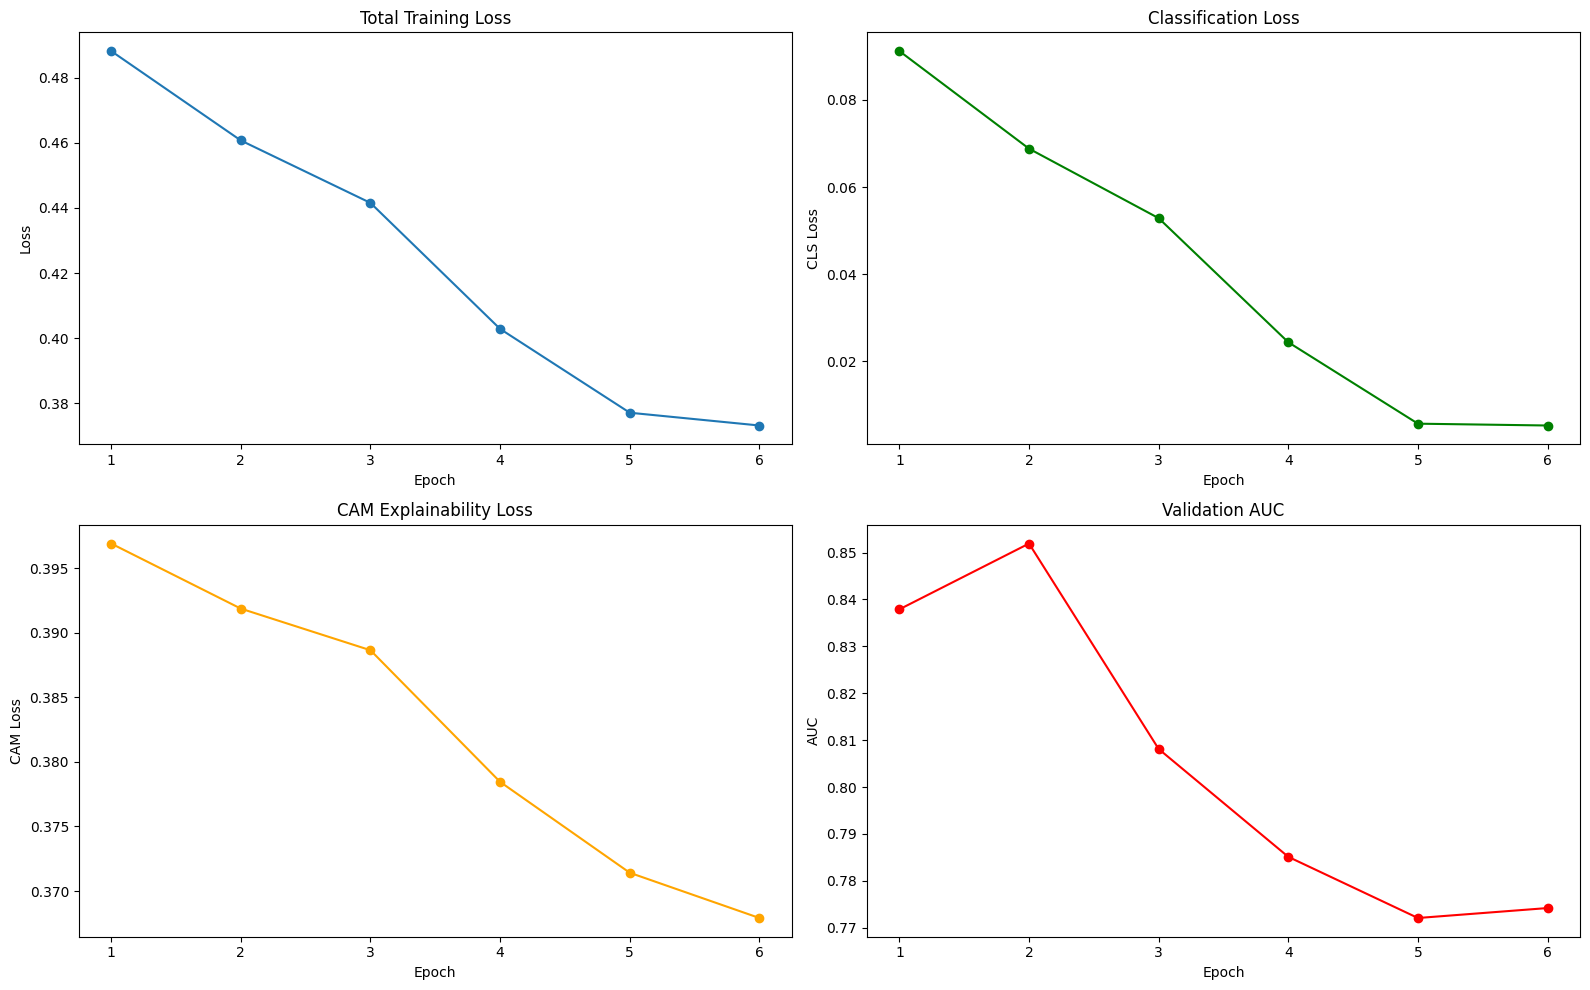

Best AUC: 0.8519289585710038


In [16]:
# =============================================================
# CELL 13 — Training Curves & Metric Analysis
# =============================================================

import pandas as pd
import matplotlib.pyplot as plt

log_path = os.path.join(BASE_DRIVE, "training_log.csv")
df_log = pd.read_csv(log_path)

plt.figure(figsize=(16,10))

# --- Total Loss ---
plt.subplot(2,2,1)
plt.plot(df_log["epoch"], df_log["train_loss"], marker='o')
plt.title("Total Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# --- Classification Loss ---
plt.subplot(2,2,2)
plt.plot(df_log["epoch"], df_log["train_cls_loss"], marker='o', color='green')
plt.title("Classification Loss")
plt.xlabel("Epoch")
plt.ylabel("CLS Loss")

# --- CAM Loss ---
plt.subplot(2,2,3)
plt.plot(df_log["epoch"], df_log["train_cam_loss"], marker='o', color='orange')
plt.title("CAM Explainability Loss")
plt.xlabel("Epoch")
plt.ylabel("CAM Loss")

# --- Validation AUC ---
plt.subplot(2,2,4)
plt.plot(df_log["epoch"], df_log["val_auc"], marker='o', color='red')
plt.title("Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")

plt.tight_layout()
plt.show()

print("Best AUC:", df_log["val_auc"].max())


CELL 14 — Full test evaluation: AUC, Sens@95, Dice, bias gaps by skin_bin

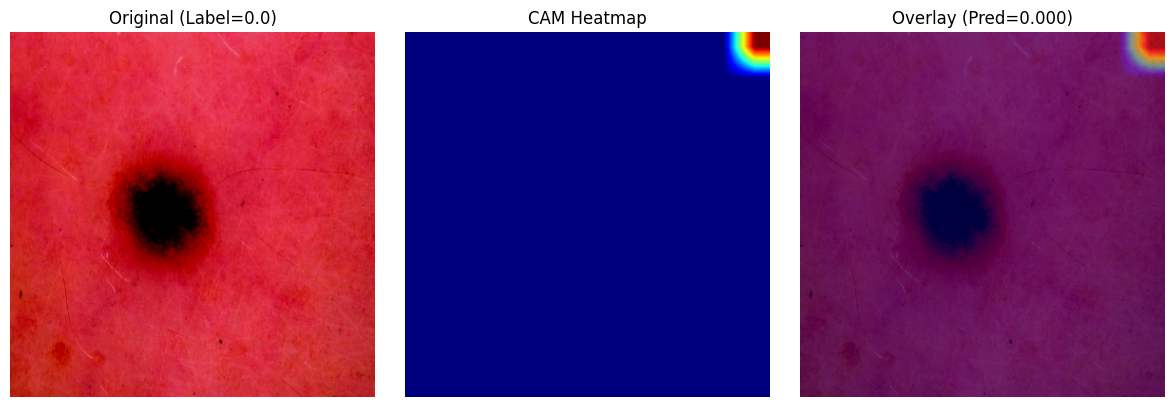

In [17]:
# =============================================================
# CELL 14 — CAM Visualization on Test Samples
# =============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_cam(model, img_tensor):
    cls_layer = model.get_layer("cls_logits")
    feats = feature_extractor(img_tensor, training=False)
    cls_kernel = cls_layer.kernel[:,0]

    cam = compute_cam(feats, cls_kernel)[0].numpy()
    cam = cam.squeeze()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    return cam

# Take one batch from test set
sample = next(iter(test_ds))
img = sample["image"][0:1]
label = sample["label"][0]

# Prediction
_, pred = model(img, training=False)
pred_score = float(pred.numpy()[0][0])

# CAM
cam = visualize_cam(model, img)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img[0].numpy())
plt.title(f"Original (Label={label.numpy()})")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cam, cmap='jet')
plt.title("CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img[0].numpy())
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title(f"Overlay (Pred={pred_score:.3f})")
plt.axis("off")

plt.tight_layout()
plt.show()


Prediction score: 0.0085
Prediction: Benign


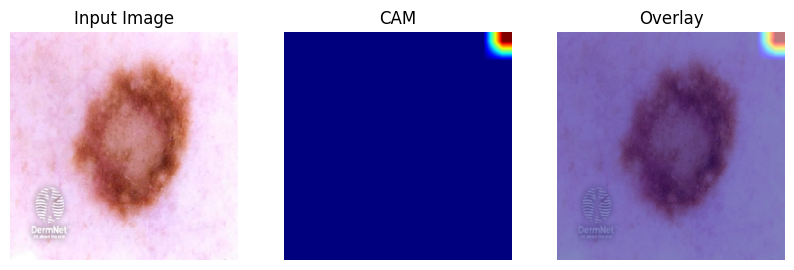

In [23]:
# =============================================================
# CELL 15 — Single Image Test (Inference Demo)
# =============================================================

from tensorflow.keras.preprocessing import image

def predict_single_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    _, pred = model(img, training=False)
    score = float(pred.numpy()[0][0])

    print(f"Prediction score: {score:.4f}")
    print("Prediction:", "Melanoma" if score >= 0.5 else "Benign")

    cam = visualize_cam(model, img)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(img[0])
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cam, cmap="jet")
    plt.title("CAM")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img[0])
    plt.imshow(cam, cmap="jet", alpha=0.5)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()


predict_single_image("/content/benign.jpg")


In [19]:
# =============================================================
# CELL 16 — Load Best Model & Download
# =============================================================

from google.colab import files
import os

# ---- Path to BEST model (update if needed)
BEST_MODEL_PATH = "/content/drive/MyDrive/HAM_project/checkpoints/best_epoch5_auc0.9063.weights.h5"

# ---- Load weights into model
model.load_weights(BEST_MODEL_PATH)
print("✔ Best model weights loaded")

# ---- Save full model (architecture + weights)
EXPORT_PATH = "/content/skin_lesion_resnet_cam.keras"
model.save(EXPORT_PATH)

print("✔ Model saved as:", EXPORT_PATH)

# ---- Download to local machine
files.download(EXPORT_PATH)


✔ Best model weights loaded
✔ Model saved as: /content/skin_lesion_resnet_cam.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
files.download(BEST_MODEL_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>